# Goal: Classify iris flowers

In [1]:
# Loading Data
import pandas as pd

file_path = "datasets/iris/data/iris.data"
iris = pd.read_csv(file_path)
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [2]:
# Splitting train and test data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(iris, test_size=0.2, random_state=42)
train_set.head()

,sepal_length,sepal_width,petal_length,petal_width,class
22,4.6,3.6,1.0,0.2,Iris-setosa
15,5.7,4.4,1.5,0.4,Iris-setosa
65,6.7,3.1,4.4,1.4,Iris-versicolor
11,4.8,3.4,1.6,0.2,Iris-setosa
42,4.4,3.2,1.3,0.2,Iris-setosa


In [3]:
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

## Exploratory Data Anlaysis

In [4]:
train_set.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,120.000000,120.000000,120.000000,120.000000
mean,5.809167,3.057500,3.727500,1.182500
std,0.823805,0.446398,1.751252,0.753442
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.500000,0.300000
50%,5.750000,3.000000,4.250000,1.300000
75%,6.400000,3.325000,5.100000,1.800000
max,7.700000,4.400000,6.700000,2.500000


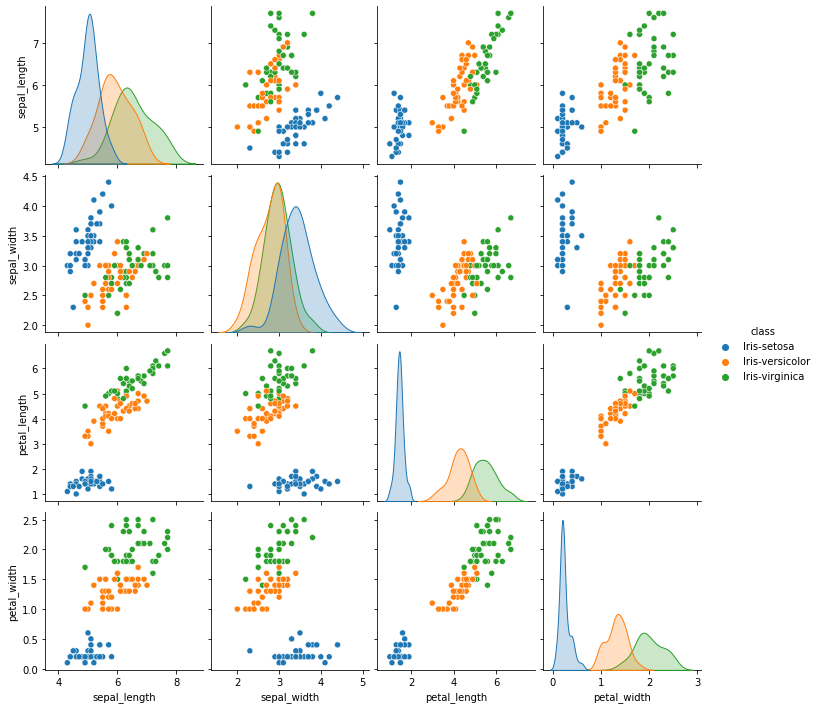

In [5]:
# Pairplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(train_set, hue='class')
plt.show()

<AxesSubplot:>

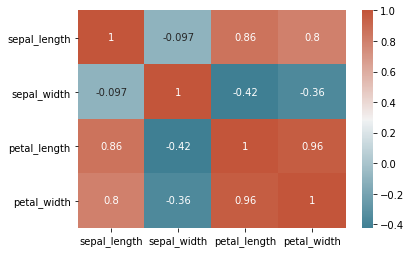

In [6]:
# Correlation Matrix
corr_mx = train_set.corr()

sns.heatmap(corr_mx,
            xticklabels=corr_mx.columns,
           yticklabels=corr_mx.columns,
           annot=True,
           cmap=sns.diverging_palette(220, 20, as_cmap=True))

## Preparing Data

In [14]:
# Preparing ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_features = X_train.select_dtypes(include=['float64']).columns
col_trans = ColumnTransformer(transformers=[
    ('num_transformer', StandardScaler(), num_features)
])

X_train_prep = col_trans.fit_transform(X_train)
X_test_prep = col_trans.fit_transform(X_test)

## Machine Learning

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluation Function
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

def cross_val_model(model):
    pipeline = Pipeline([
        ('prep', col_trans),
        ('model', model),
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print('Accuracy of %s: %.3f with STD of %.3f' % (model, np.mean(scores), np.std(scores)))

In [12]:
# Cross Validation of Models
models = [LogisticRegression(), SVC(), KNeighborsClassifier(), RandomForestClassifier()]

for model in models:
    cross_val_model(model)

Accuracy of LogisticRegression(): 0.958 with STD of 0.046
Accuracy of SVC(): 0.950 with STD of 0.061
Accuracy of KNeighborsClassifier(): 0.933 with STD of 0.057
Accuracy of RandomForestClassifier(): 0.950 with STD of 0.041


In [30]:
# Testing models function
def predict_test(model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    acc = accuracy_score(preds, y_test)
    con_mx = confusion_matrix(preds, y_test)
    class_rep = classification_report(preds, y_test)
    print(acc)
    print(con_mx)
    print(class_rep)

In [31]:
# Logistic Regression
log_reg = LogisticRegression()
predict_test(log_reg)

0.9666666666666667
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



## Deep Learning

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
y_train_encoded = lab_encoder.fit_transform(y_train)
y_test_encoded = lab_encoder.fit_transform(y_test)

# Set Random Seed
tf.random.set_seed(42)

# Create Model
input_shape = [X_train_prep.shape[1]]
dl_model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=input_shape),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='softmax'),
])

# Compile Model
dl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit Model
history = dl_model.fit(X_train_prep, y_train_encoded, epochs=10, verbose=0)

In [82]:
#Testing model
dl_preds = dl_model.predict(X_test_prep)
acc = accuracy_score(dl_preds, y_test_encoded)
print(acc)

0.3
